In [20]:
import pandas as pd
import numpy as np
import warnings
import datetime
import geopy.distance

warnings.filterwarnings("ignore")

In [21]:
df = pd.read_csv("bookinghistory.csv", low_memory=False)

In [22]:
df.dropna(subset=['battery_level_at_start','battery_level_at_end'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [23]:
df.drop(['id', 'bookind_id', 'driver_login', 'start_location', 'trip_fare', 'car_group', 'start_zone_name', 'end_zone_name', 'booking_end', 'cp__end', 'cp__start', 'customer_id', 'ignore_relocation_bonus', 'associated_pfm', 'not_invoiced', 'associated_pfr', 'already_invoiced', 'last_update', 'rating', 'car_histoy_match', 'rating_description', 'notif_booking_finished_no_pfr', 'notif_booking_ongoing_no_reservation', 'pk_driver', 'reason_for_no_pfr', 'bonus_malus', 'account', 'car_history_match', 'otoqi_reference', 'city'], axis=1, inplace = True)


### Sort dataframe by date & create new columns & correct columns

In [24]:
df['start_date_time']= pd.to_datetime(df['booking_start_date__date'].astype(str), infer_datetime_format=True)
df['end_date_time']= pd.to_datetime(df['booking_end_date__date'].astype(str), infer_datetime_format=True)

In [25]:
df = df.sort_values(by="start_date_time")

In [26]:
df = df.drop_duplicates(subset=['booking_id'], keep='first')

In [27]:
df["charging"] = (df['battery_level_at_end']-df['battery_level_at_start']>1)

In [28]:
df['mileage_end'] = df[["mileage_end", "mileage_start"]].max(axis=1)

In [29]:
df['battery_level_at_end'] = pd.to_numeric(df['battery_level_at_end']).astype(int)
df['battery_level_at_start'] = pd.to_numeric(df['battery_level_at_start']).astype(int)

In [30]:
df['delta'] = df['battery_level_at_end']-df['battery_level_at_start']

In [31]:
df['month'] = df['start_date_time'].dt.month
month_dict = {2:"Février", 3: "Mars", 4:"Avril", 5: "Mai", 6: "Juin"}
df['month'] = df['month'].map(month_dict)

In [32]:
df['car_model'] = df['car_model'].replace({'Zoe': 'ZOE'})

### Charging Sessions

In [33]:
def getSessions(dataframe):
    """
        Returns charging sessions for input dataframe with only one plate number
    """
    dataframe.reset_index(drop=True, inplace=True)
    plate = dataframe.loc[0, 'plate_number']
    model = dataframe.loc[0, 'car_model']
    dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
    dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
    dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
    dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
    dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
    for index in range(len(dataframe)):
        if dataframe.loc[index, 'battery_drop']/(dataframe.loc[index, 'delta_hours']+1) > 5:
            dataframe.loc[index, 'battery_level_at_start'] = dataframe.loc[index, 'last_end_battery']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']
        if (dataframe.loc[index, 'battery_level_at_start'] - dataframe.loc[index, 'battery_level_at_end'])/(dataframe.loc[index, 'duration']+1)>30:
            dataframe.loc[index, 'battery_level_at_end'] = dataframe.loc[index, 'battery_level_at_start']
            dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
            dataframe['last_end_date']=dataframe['end_date_time'].shift(1)
            dataframe['delta_hours'] = (dataframe['start_date_time']-dataframe['last_end_date']).astype('timedelta64[h]')
            dataframe['duration'] = (dataframe['end_date_time']-dataframe['start_date_time']).astype('timedelta64[h]')
            dataframe['battery_drop'] = dataframe['last_end_battery']-dataframe['battery_level_at_start']
            dataframe['delta'] = dataframe['battery_level_at_end']-dataframe['battery_level_at_start']

    
    dataframe.reset_index(drop=True, inplace=True)
    dataframe['last_end_battery']=dataframe['battery_level_at_end'].shift(1)
    dataframe['was_charging']=(dataframe['battery_level_at_start']-dataframe['last_end_battery']>0)
    dataframe["charging"] = (dataframe['battery_level_at_end']-dataframe['battery_level_at_start']>0)
    charging_sessions = []
    index = 0
    current_start = 0
    start = ""
    start_battery = 0
    current_last = 0
    open_booking = False
    while index < len(dataframe) :
        if open_booking: # car was charging
            if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
                open_booking = False
                if dataframe.loc[index, 'was_charging']:
                    charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[current_start, 'end_adress'], dataframe.loc[current_start, 'end_location'], dataframe.loc[current_start, 'driver'], dataframe.loc[current_start+1, 'driver'], dataframe.loc[current_start, 'mileage_end'], dataframe.loc[current_start, 'booking_id']))
                else :
                    charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index-1, 'end_date_time'], start_battery, dataframe.loc[current_last, 'battery_level_at_end'], dataframe.loc[current_start, 'end_adress'], dataframe.loc[current_start, 'end_location'], dataframe.loc[current_start, 'driver'], dataframe.loc[current_start+1, 'driver'], dataframe.loc[current_start, 'mileage_end'], dataframe.loc[current_start, 'booking_id']))
                
            else : # car is still charging
                current_last = index
        else : # car wasn't charging
            if dataframe.loc[index, 'was_charging']: # the car was charged since last booking
                open_booking = True
                current_start = index-1
                start = 'end_'
                current_last = index
                start_battery = dataframe.loc[current_start, 'battery_level_at_end']
                if not dataframe.loc[index, 'charging']: # car is not charging anymore --> close session
                    open_booking = False
                    charging_sessions.append((plate, model, dataframe.loc[current_start, start+'date_time'], dataframe.loc[index, 'start_date_time'], start_battery, dataframe.loc[index, 'battery_level_at_start'], dataframe.loc[current_start, 'end_adress'], dataframe.loc[current_start, 'end_location'], dataframe.loc[current_start, 'driver'], dataframe.loc[current_start+1, 'driver'], dataframe.loc[current_start, 'mileage_end'], dataframe.loc[current_start, 'booking_id']))
            else :
                if dataframe.loc[index, 'charging']:
                    open_booking = True
                    current_start = index
                    start = "start_"
                    current_last = index
                    start_battery = dataframe.loc[index, 'battery_level_at_start']
                
        index += 1
    return charging_sessions

In [34]:
plates = df.plate_number.unique()
plate = plates[0]

In [35]:
sessions = []
for plate in plates :
    dataframe = df[df['plate_number']==plate]
    sessions += getSessions(dataframe)
    
sessions_df = pd.DataFrame(sessions, columns = ['plate_number', 'model', 'start_date', 'end_date', 'start_battery', 'end_battery', 'adress', 'location', 'driver', 'next_driver', 'mileage', 'booking_id'])

### Calculate columns

In [36]:
sessions_df.head()

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,location,driver,next_driver,mileage,booking_id
0,FB-386-YK,ZOE,2022-03-30 00:37:22,2022-03-30 11:05:04,12.0,13.0,"Quai de Clichy, 92110 Clichy, France","48.90898514, 2.30129933",Client,Van Huy NGUYEN,15929.0,RZTY8949870
1,FB-386-YK,ZOE,2022-03-30 11:30:13,2022-03-30 13:18:19,9.0,85.0,"15 Av. Charles de Gaulle, 92100 Boulogne-Billa...","48.85002136, 2.23768306",Van Huy NGUYEN,Van Huy NGUYEN,15939.0,RZTY8951370
2,FB-386-YK,ZOE,2022-04-04 23:47:56,2022-04-05 08:56:17,72.0,73.0,"9 Rue Franquet, 75015 Paris, France","48.83307648, 2.30647016",Client,Client,15967.0,RZTY8981128
3,FB-386-YK,ZOE,2022-04-06 23:58:21,2022-04-07 12:18:00,49.0,50.0,"4 Rue dOlivet, 75007 Paris, France","48.84959412, 2.31942487",Client,Client,16019.0,RZTY8990388
4,FB-386-YK,ZOE,2022-04-07 18:31:00,2022-04-08 15:39:00,49.0,50.0,"4 Rue dOlivet, 75007 Paris, France","48.84970474, 2.31943798",Client,Client,16019.0,RZTY8994045


In [39]:
sessions_df['delta'] = (sessions_df['end_battery']-sessions_df['start_battery'])
sessions_df = sessions_df[sessions_df['delta'] > 3]
sessions_df['month'] = sessions_df['start_date'].dt.month
month_dict = {2:"Février", 3: "Mars", 4:"Avril", 5: "Mai", 6: "Juin"}
sessions_df['month'] = sessions_df['month'].map(month_dict)
sessions_df['date0'] = pd.to_datetime([datetime.date(year=2022, month=1, day=1) for x in sessions_df.iterrows()])
sessions_df['day']=(sessions_df['start_date']-sessions_df['date0']).dt.days+1
sessions_df['created_id']=sessions_df['plate_number']+sessions_df['driver']+sessions_df['day'].astype(str)
sessions_df.drop(['date0'], axis=1, inplace=True)

In [40]:
sessions_df['last_mileage'] = sessions_df['mileage'].shift(1)
sessions_df['last_plate'] = sessions_df['plate_number'].shift(1)
sessions_df['distance'] = sessions_df['mileage'] - sessions_df['last_mileage']
sessions_df.loc[sessions_df['last_plate']!=sessions_df['plate_number'], 'distance'] = 0

In [41]:
sessions_df['kWh'] = 0
sessions_df['kWh_used']=0
sessions_df['battery_used'] = sessions_df['end_battery'].shift(1)-sessions_df['start_battery']

In [42]:
sessions_df.loc[sessions_df['model']=='ZOE', 'kWh'] = sessions_df.loc[sessions_df['model']=='ZOE', 'delta']*40/100
sessions_df.loc[sessions_df['model']=='Spring', 'kWh'] = sessions_df.loc[sessions_df['model']=='Spring', 'delta']*27/100
sessions_df.loc[sessions_df['model']=='ZOE', 'kWh_used'] = sessions_df.loc[sessions_df['model']=='ZOE', 'battery_used']*40/100
sessions_df.loc[sessions_df['model']=='Spring', 'kWh_used'] = sessions_df.loc[sessions_df['model']=='Spring', 'battery_used']*27/100
sessions_df['consumption'] = sessions_df['kWh_used']/sessions_df['distance']


In [43]:
sessions_df['kWh']=pd.to_numeric(sessions_df['kWh'])
sessions_df['kWh_used']=pd.to_numeric(sessions_df['kWh_used'])

## Add 'site' column to match BUMP record --> do it with location...

In [123]:
def site(address):
    if ("Rue Censier" in address) or ("Jardin des Plantes" in address) or ("Geoffroy" in address) or ("Daubenton" in address) or ("Santeuil" in address) or ("Fer À Moulin" in address) or ("Georges Desplas" in address) or ("Poliveau" in address) or ("La Mosquée, 75005" in address) or ("Buffon" in address):
        return "BMP - Paripark - Jardin des Plantes - Paris | 15 Rue Censier, 75005 Paris, France"
    elif ("Moulin des" in address) or ("Tolbiac" in address) or ("Moulinet" in address):
        return "BMP - Paripark - Moulin des Près - Paris | 62 Rue du Moulin des Prés, 75013 Paris, France"
    elif ("Metra" in address) or ("Métra" in address) or ('Rigoles' in address) or ("Pyrénées" in address) or ("Lemaître" in address) or ("l'Ermitage" in address) or ("lErmitage" in address) or ("Belleville" in address):
        return "BMP - Paripark - Olivier Metra - Paris | 35-49 Rue Olivier Métra, 75020 Paris"
    elif ("Christine de Pisan" in address) or ("Saussure" in address) or ("Georges Picquart" in address) or ("Pereire" in address) or ("Voie Provisoire BV/17" in address):
        return "BMP - Parking AVE - 17e | 7 Rue Christine de Pisan, 75017 Paris, France"
    elif "Chardon Lagache" in address:
        return "Belib/B90-1609 | 2 Rue Chardon Lagache"
    elif "Ordener" in address:
        return "Belib/B90-1805 | 27 Rue Ordener"
    elif "Frères Voisin" in address:
        return "Freshmile/SUERDA | 26 Allée des Frères Voisin"
    elif "Léon Renault" in address:
        return "La borne bleue/qznBqG3joK | 17 Rue Léon Renault"
    elif ("École de Médecine" in address) or ("SAEMES" in address) or ("Hautefeuille" in address):
        return "SAEMES/SAE-EDM | 21 Rue de l'École de Médecine"
    elif "Avenue de la Cristallerie" in address:
        return "SIGEIF et Izivia/FR*SIG*PSIGE*49 | 2 Avenue de la Cristallerie"
    elif "Boulevard Victor Hugo" in address:
        return "SIGEIF et Izivia/FR*SIG*PSIGE*89 | 123 Boulevard Victor Hugo"
    elif "Avenue du Maréchal Foch" in address:
        return "ATotal/TOTAL-NF058742 | Avenue du Maréchal Foch"
    elif "Rue de Strasbourg" in address:
        return "Total/TOTAL-NF059983 | 1 Rue de Strasbourg"
    elif ("Zity" in address) or ("Yves Kermen" in address) or ("Boulogne-Billancourt" in address):
        return 'Zity'
    else :
        return "NO MATCH"

In [79]:
def loc_site(coords, radius):
    if geopy.distance.geodesic(coords, (48.84085668270345, 2.3547124332890457)).km < radius:
        return "BMP - Paripark - Jardin des Plantes - Paris | 15 Rue Censier, 75005 Paris, France"
    elif geopy.distance.geodesic(coords, (48.8267037597978, 2.3531090981614864)).km < radius:
        return "BMP - Paripark - Moulin des Près - Paris | 62 Rue du Moulin des Prés, 75013 Paris, France"
    elif geopy.distance.geodesic(coords, (48.873684950802044, 2.393388557688522)).km < radius:
        return "BMP - Paripark - Olivier Metra - Paris | 35-49 Rue Olivier Métra, 75020 Paris"
    elif geopy.distance.geodesic(coords, (48.88948797132723, 2.308701830754263)).km < radius:
        return "BMP - Parking AVE - 17e | 7 Rue Christine de Pisan, 75017 Paris, France"
    elif geopy.distance.geodesic(coords, (48.845888346615055, 2.2673247046686034)).km < radius:
        return "Belib/B90-1609 | 2 Rue Chardon Lagache"
    elif geopy.distance.geodesic(coords, (48.890703253173214, 2.354113050057324)).km < radius:
        return "Belib/B90-1805 | 27 Rue Ordener"
    elif geopy.distance.geodesic(coords, (48.82802014590191, 2.2716522760732465)).km < radius:
        return "Freshmile/SUERDA | 26 Allée des Frères Voisin"
    elif geopy.distance.geodesic(coords, (48.88124877267117, 2.4227016430401584)).km < radius:
        return "La borne bleue/qznBqG3joK | 17 Rue Léon Renault"
    elif geopy.distance.geodesic(coords, (48.85101291450305, 2.341009648307103)).km < radius:
        return "SAEMES/SAE-EDM | 21 Rue de l'École de Médecine"
    elif geopy.distance.geodesic(coords, (48.82681595930142, 2.2231016911032877)).km < radius:
        return "SIGEIF et Izivia/FR*SIG*PSIGE*49 | 2 Avenue de la Cristallerie"
    elif geopy.distance.geodesic(coords, (48.90231124074938, 2.317810962179574)).km < radius:
        return "SIGEIF et Izivia/FR*SIG*PSIGE*89 | 123 Boulevard Victor Hugo"
    elif geopy.distance.geodesic(coords, (48.90382732824149, 2.084128075565785)).km < radius:
        return "ATotal/TOTAL-NF058742 | Avenue du Maréchal Foch"
    elif geopy.distance.geodesic(coords, (48.891198447656116, 2.2475660676664218)).km < radius:
        return "Total/TOTAL-NF059983 | 1 Rue de Strasbourg"
    elif geopy.distance.geodesic(coords, (48.826157610628314, 2.2455017759875027)).km < radius:
        return 'Zity'
    else :
        return "NO MATCH"

In [80]:
sessions_df['site'] = sessions_df['location'].map(lambda x: (loc_site(x, 0.4)))

In [81]:
sessions_df

,plate_number,model,start_date,end_date,start_battery,end_battery,adress,location,driver,next_driver,...,day,created_id,kWh,kWh_used,battery_used,last_mileage,last_plate,distance,consumption,site
1,FB-386-YK,ZOE,2022-03-30 11:30:13,2022-03-30 13:18:19,9.0,85.0,"15 Av. Charles de Gaulle, 92100 Boulogne-Billa...","48.85002136, 2.23768306",Van Huy NGUYEN,Van Huy NGUYEN,...,89,FB-386-YKVan Huy NGUYEN89,30.40,NaN,NaN,NaN,NaN,0.0,NaN,NO MATCH
7,FB-386-YK,ZOE,2022-04-11 20:19:00,2022-04-13 19:55:24,15.0,100.0,"5bis Rue Mahias, 92100 Boulogne-Billancourt, F...","48.84577179, 2.234308",Madil Berkani,Madil Berkani,...,101,FB-386-YKClient101,34.00,28.00,70.0,15939.0,FB-386-YK,163.0,0.171779,NO MATCH
9,FB-386-YK,ZOE,2022-04-18 16:39:24,2022-04-19 19:16:26,14.0,100.0,"12 Rue de lÉcole de Médecine, 75006 Paris, France","48.85112381, 2.34090495",luc talbot,Alexandre Makunga,...,108,FB-386-YKluc talbot108,34.40,34.40,86.0,16102.0,FB-386-YK,237.0,0.145148,SAEMES/SAE-EDM | 21 Rue de l'École de Médecine
10,FB-386-YK,ZOE,2022-04-24 19:18:29,2022-04-25 17:40:24,14.0,100.0,"40ter Rue Olivier Métra, 75020 Paris, France","48.8736496, 2.39352894",Daniel Da Silva Meneses Campos,luc talbot,...,114,FB-386-YKDaniel Da Silva Meneses Campos114,34.40,34.40,86.0,16339.0,FB-386-YK,240.0,0.143333,BMP - Paripark - Olivier Metra - Paris | 35-49...
17,FB-386-YK,ZOE,2022-05-09 16:52:00,2022-05-16 12:18:00,16.0,99.0,"79 Pl. Saint-Jacques, 75014 Paris, France","48.83380127, 2.3364501",Zity Paris 1,Client,...,129,FB-386-YKZity Paris 1129,33.20,33.60,84.0,16579.0,FB-386-YK,205.0,0.163902,NO MATCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,GB-945-JX,Spring,2022-05-15 15:34:00,2022-05-15 18:02:00,48.0,100.0,"12 Rue Censier, 75005 Paris, France","48.8409462, 2.35452151",Seraphin TAM,Seraphin TAM,...,135,GB-945-JXSeraphin TAM135,14.04,0.00,0.0,1902.0,GB-945-JX,0.0,NaN,BMP - Paripark - Jardin des Plantes - Paris | ...
9071,GB-945-JX,Spring,2022-05-23 12:42:00,2022-05-23 14:14:00,11.0,100.0,"6 Rue Santeuil, 75005 Paris, France","48.83982086, 2.35476589",Alexandre Makunga,Client,...,143,GB-945-JXAlexandre Makunga143,24.03,24.03,89.0,1902.0,GB-945-JX,185.0,0.129892,BMP - Paripark - Jardin des Plantes - Paris | ...
9072,GB-945-JX,Spring,2022-05-29 00:59:00,2022-05-29 02:25:00,6.0,100.0,"4 Rue Christine de Pisan, 75017 Paris, France","48.8890419, 2.30907369",hicham boulahtit,hicham boulahtit,...,149,GB-945-JXhicham boulahtit149,25.38,25.38,94.0,2087.0,GB-945-JX,189.0,0.134286,BMP - Parking AVE - 17e | 7 Rue Christine de P...
9073,FZ-866-RF,Spring,2022-05-24 12:23:00,2022-05-25 17:29:00,4.0,57.0,"28 Rue Yves Kermen, 92100 Boulogne-Billancourt...","48.82683945, 2.24457741",Armand LEVEQUE,florian arnault,...,144,FZ-866-RFArmand LEVEQUE 144,14.31,25.92,96.0,2276.0,GB-945-JX,0.0,inf,Zity


In [83]:
sessions_df['site'].value_counts()

BMP - Paripark - Olivier Metra - Paris | 35-49 Rue Olivier Métra, 75020 Paris                840
BMP - Paripark - Jardin des Plantes - Paris | 15 Rue Censier, 75005 Paris, France            791
BMP - Parking AVE - 17e | 7 Rue Christine de Pisan, 75017 Paris, France                      713
BMP - Paripark - Moulin des Près - Paris | 62 Rue du Moulin des Prés, 75013 Paris, France    634
Freshmile/SUERDA | 26 Allée des Frères Voisin                                                590
NO MATCH                                                                                     438
SAEMES/SAE-EDM | 21 Rue de l'École de Médecine                                               121
Zity                                                                                          70
SIGEIF et Izivia/FR*SIG*PSIGE*89 | 123 Boulevard Victor Hugo                                   6
Belib/B90-1609 | 2 Rue Chardon Lagache                                                         5
Belib/B90-1805 | 27 Rue Ordene

## When charge is from a client, check if the next booking is from a driver

In [84]:
sessions_df.loc[sessions_df['driver']=='Client', 'driver'] = sessions_df.loc[sessions_df['driver']=='Client', 'next_driver']

### Tests and plots

In [85]:
print(len(sessions_df[sessions_df['model']=="ZOE"][sessions_df['distance']>395]))

8


In [86]:
zoe_percent = sessions_df[sessions_df['model']=='ZOE'][sessions_df['month']=='Mai']['delta'].sum()
spring_percent = sessions_df[sessions_df['model']=='Spring'][sessions_df['month']=='Mai']['delta'].sum()

In [87]:
zoe_kwh = zoe_percent*40/100
spring_kwh = spring_percent*27/100

In [88]:
print(zoe_kwh, spring_kwh)

21732.8 28077.57


In [89]:
print(zoe_kwh+spring_kwh)

49810.369999999995


<AxesSubplot:xlabel='start_date'>

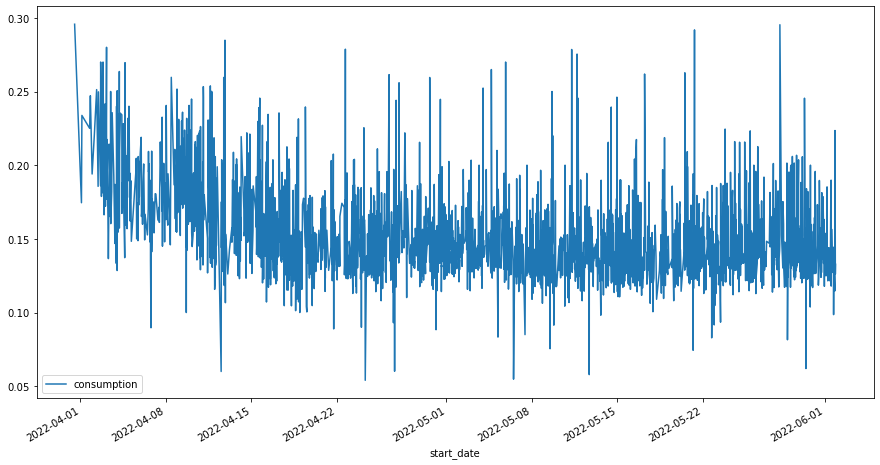

In [90]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0][sessions_df['consumption']<0.3][sessions_df['consumption']>0.05].plot(x='start_date', y='consumption', figsize=(15, 8))

<AxesSubplot:xlabel='start_date'>

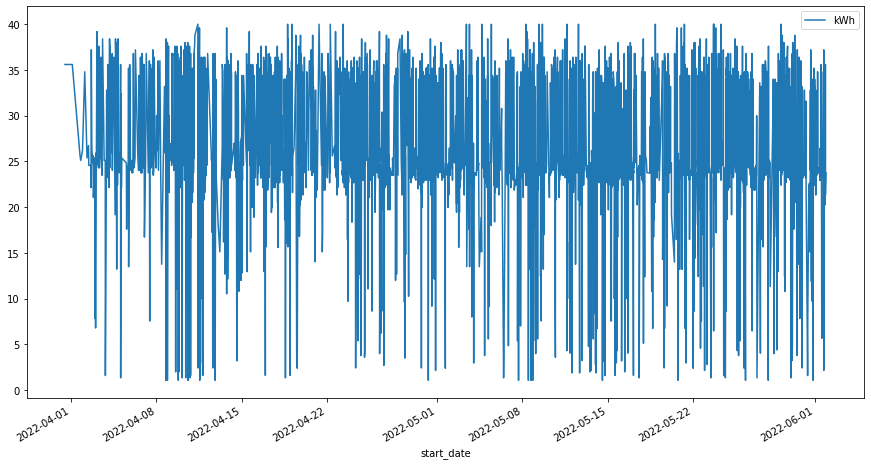

In [91]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0][sessions_df['consumption']<0.3][sessions_df['consumption']>0.05].plot(x='start_date', y='kWh', figsize=(15, 8))

In [92]:
sessions_df[sessions_df['distance']!=0][sessions_df['battery_used']>0][sessions_df['consumption']<0.3][sessions_df['consumption']>0.05]['kWh'].describe()

count    3424.000000
mean       26.149550
std         7.446373
min         1.080000
25%        23.490000
50%        24.840000
75%        32.900000
max        40.000000
Name: kWh, dtype: float64

In [93]:
sessions_df['driver'].value_counts()

Van Huy NGUYEN       620
Madil Berkani        355
Moke N Kazi          340
Mathias Riguet       281
Alexandre Makunga    243
                    ... 
RRG Courbevoie         1
Abou DIABY             1
Zity Paris 2           1
Jordi Carbonell        1
RRG Charenton          1
Name: driver, Length: 74, dtype: int64

In [94]:
sessions_df[sessions_df['model']=='ZOE']['kWh'].describe()

count    1467.000000
mean       31.785958
std         8.189801
min         1.600000
25%        32.000000
50%        34.400000
75%        36.000000
max        40.000000
Name: kWh, dtype: float64

In [95]:
sessions_df[sessions_df['driver']=="Client"]['kWh'].sum()

798.41

In [96]:
sessions_df['consumption'].value_counts()

 inf         516
 0.135000     33
-0.000000     23
 0.133333     14
 0.150000     12
            ... 
 0.113496      1
 0.162679      1
 0.138506      1
 0.152601      1
 0.129685      1
Name: consumption, Length: 2150, dtype: int64

In [97]:
print(len(sessions_df.loc[sessions_df['driver']=="Client"]))

91


In [102]:
sessions_df[sessions_df['site']!='NO MATCH'][sessions_df['month']!='Mai']['kWh'].sum()

51714.84

In [103]:
sessions_df[sessions_df['site']!='NO MATCH'][sessions_df['month']!='Avril']['kWh'].sum()

49467.9

In [100]:
df.loc[df['booking_id']=="RZTY9227697"]

,plate_number,driver,start_adress,end_adress,end_location,mileage_start,mileage_end,booking_end_date__date,booking_start_date__date,distance,battery_level_at_start,battery_level_at_end,car_model,booking_id,start_date_time,end_date_time,charging,delta,month
26726,GB-945-JX,Client,"6 Rue Santeuil, 75005 Paris, France","6 Rue Santeuil, 75005 Paris, France","48.83982086, 2.35476589",2087.0,2087.0,5/23/2022 2:34:00 PM,5/23/2022 2:14:00 PM,0,100,100,Spring,RZTY9227697,2022-05-23 14:14:00,2022-05-23 14:34:00,False,0,Mai


In [101]:
sessions_df.to_csv("charging_sessions2.csv")